# BM25

## Introduction

BM25 - Best match 25 algorithm has been a classic algorithm used for search. Note that this is a lexical search algorithm and not a contextual/semantic search.

It's called BM25 as it is the 25th iteration of tweaking the relevance computation. Roots in probabilistic information retrieval

Elastic Search uses Okapi BM25



BM25 algorithm was introduced by Robertson and Walker in 1994 as an improvement over the previous Okapi BM11 algorithm

## Basic Intuition

The broad goal is similar as any other search - Given a query, you want to surface relevant hits
BM25 makes the basic assumption that for a query, relevant and non-relevant documents follow different probabilistic distributions

It broadly uses TF (Term Frequency), IDF (Inverse document frequency), Document Length normalization (To normalize for the fact that longer documents tend to have more occurences of a given query term compared to shorter documents, and that needs to be normalized), and query term saturation (to mitigate the impact of extremely term high frequencies)

A given query Q is broken up into individual terms qi, and given a document D, this is the formula for BM(Q,D) : 

BM25(D, Q) = ∑(IDF(q) * ((TF(q, D) * (k1 + 1)) / (TF(q, D) + k1 * (1 — b + b * (|D| / avgdl)))))

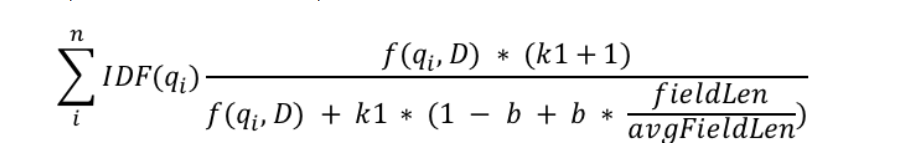

where 



1) IDF(qi) is the inverse document frequency of query word qi. The IDF formula used in BM25 is a bit different from the IDF formula used in TF-IDF, specifically,  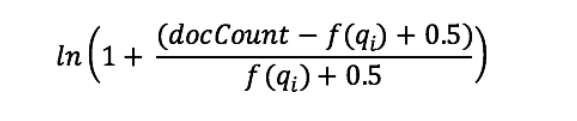


where docCount is the total no of documents, f(qi) is the number of documents where qi is present


2) f(qi,D) is the term frequency of query word qi in document D
3) fieldLen is the length of the document D
4) avgFieldLen is average document length in corpus
4) b is a  hyperparameter that control impact of  document length normalization. Note that if b=0, the term b * fieldLen/avgFieldLen  disappears , thus ensuring no document length normalization. If b is bigger, effect of the length of the document compared to average document length is optimized. In Elastic search, default value of b is 0.75
5) k1 is a hyperparameter that controls the impact of term frequency saturation. Iignoring b to decouple effects, at very large term frequency values having k1 causes the equation above to asymptote to f(qi,D) * (k1+1) / (f(qi,D) + k1) = (k1+1)/ (1 + k1/f(qi,D)) => asymptotes when f(qi,D) is very high to k1 + 1

k1 can also be thought of as the multiplicative effect/slope of an increase in term frequency on the final score, if term frequency is less than k1, impact of tf on the score grows quickly, if term frequency is higher than k1, impact is lesser

By default k1 has a value of 1.2 in Elastic search

## Advantages of BM25

1) Simple, effective
2) Can handle large document collections relatively easily
3) Accounts for document length bias because the b term

## Disadvangtages of BM25

1) Does not consider the semantic meaning or context. For example, from this video
https://www.youtube.com/watch?v=apuDeylm1uE


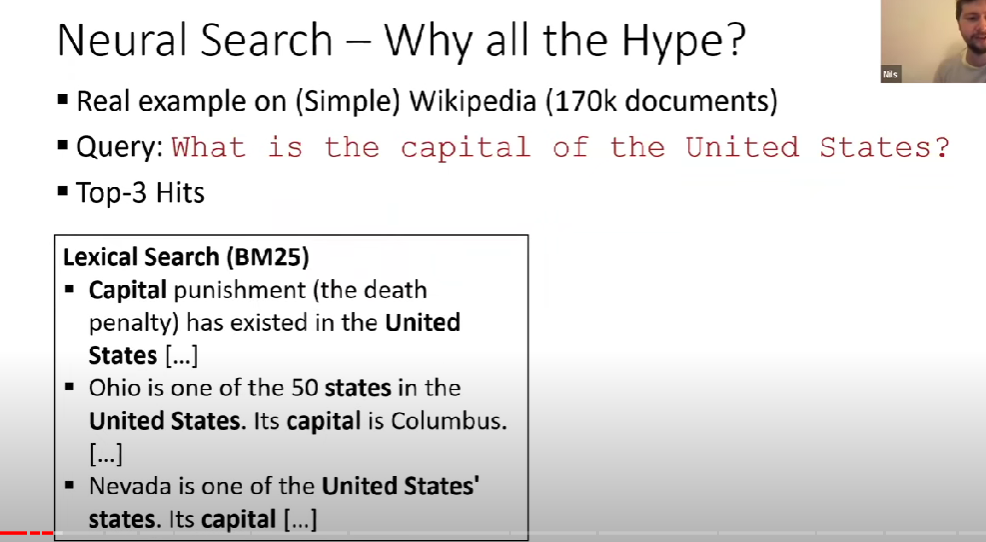

It doesn't understand the semantic meaning of the query, and so catches false positives like capital in an irrelevant context, nevada's capital instead of US capital, etc

2) Assumes query terms are statistically independent which is not always true
3) Relies heavily on TF and IDF, ignoring other aspects like document structure, relevance feedback

## Code from scratch

In [21]:
import math
from collections import Counter

class BM25():
    
    def __init__(self, documents):
        
        self.documents = documents
        self.documents_count = len(documents)
        self.avg_doc_len = sum([len(x) for x in documents])/self.documents_count
        self.term_counts = self._calculate_term_counts()
        self.k1 = 1.2
        self.b = 0.75
        
    def _calculate_term_counts(self):
        
        term_counts = Counter()
        for document in self.documents:
            term_counts.update(document) ## updates across document
        return term_counts
    
    def calculate_idf(self, term):
        num_documents_containing_term = sum([term in set(x) for x in self.documents])
        return math.log(1 + ((self.documents_count-num_documents_containing_term+0.5)/(num_documents_containing_term + 0.5)))
    
    def calculate_bm25_score(self, query, document):
        score = 0
        document_length = len(document)
        query_terms = Counter(query)
        
        for term in query_terms:
            if term not in self.term_counts:
                continue
            idf = self.calculate_idf(term)
            term_frequency = document.count(term)
            numerator = term_frequency*(self.k1 + 1)
            denominator = term_frequency + self.k1*(1 - self.b +  document_length/self.avg_doc_len)
            score = score + idf*numerator/denominator
        return score
    
    def return_ranking(self, query):
        document_scores = []
        for document in self.documents:
            score = self.calculate_bm25_score(query, document)
            document_scores.append((score, document))
        document_scores = sorted(document_scores, key = lambda x : x[0], reverse=True)
        return document_scores
        
        
        
        
        
        

In [16]:
documents = [
    ['apple', 'banana', 'orange', 'apple'],
    ['banana', 'orange', 'orange'],
    ['apple', 'apple', 'banana', 'banana'],
    ['orange', 'orange', 'banana']
]

In [22]:
bm25 = BM25(documents)

In [19]:
query = ['apple', 'banana']

In [23]:
output = bm25.return_ranking(query)

In [24]:
output

[(0.9569664219263567, ['apple', 'apple', 'banana', 'banana']),
 (0.9174652718582589, ['apple', 'banana', 'orange', 'apple']),
 (0.09954306387303842, ['banana', 'orange', 'orange']),
 (0.09954306387303842, ['orange', 'orange', 'banana'])]

In [4]:
from collections import Counter
term_counts = Counter()
for document in documents:
    term_counts.update(document) ## updates across document


In [5]:
term_counts

Counter({'apple': 4, 'banana': 5, 'orange': 5})

In [1]:
import math
math.log(10)

2.302585092994046

In [13]:
'apple' in term_counts

True

## References

1) https://en.wikipedia.org/wiki/Okapi_BM25 - Wikipedia article
2) https://medium.com/@evertongomede/understanding-the-bm25-ranking-algorithm-19f6d45c6ce#:~:text=BM25%20takes%20into%20account%20both,documents%20follow%20different%20statistical%20distributions. - Nice article with implementation and explanation
3) https://www.elastic.co/blog/practical-bm25-part-2-the-bm25-algorithm-and-its-variables - Nice article on BM25